
**2863.0252364993094  is the price of closing stock december 1** 

In [173]:
#this problem will be solved by using stacked LSTM
#for the sake of forecasting I will be using Keras and Tensorflow by google 



In [174]:
#step 1 is to collect the relevant data 
import pandas_datareader as pdr

In [175]:
df=pdr.get_data_tiingo('SPY',api_key='ec65699e90f4ed1b67e44146b35319927fd0808c')

In [176]:
import pandas as pd 
df.to_csv('SP500.csv') #recording historical price data

In [177]:
#reupload the dataset 
df = pd.read_csv('SP500.csv')

In [178]:
df.head()#verifying the first 5 records

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,SPY,2017-10-02 00:00:00+00:00,252.32,252.32,251.29,251.49,59022985,231.421219,231.421219,230.476530,230.659965,59022985,0.0,1.0
1,SPY,2017-10-03 00:00:00+00:00,252.86,252.89,252.23,252.32,66810169,231.916492,231.944008,231.338673,231.421219,66810169,0.0,1.0
2,SPY,2017-10-04 00:00:00+00:00,253.16,253.44,252.56,252.69,55953619,232.191644,232.448453,231.641340,231.760573,55953619,0.0,1.0
3,SPY,2017-10-05 00:00:00+00:00,254.66,254.68,253.20,253.54,63522757,233.567405,233.585748,232.228331,232.540170,63522757,0.0,1.0
4,SPY,2017-10-06 00:00:00+00:00,254.37,254.70,253.85,254.15,80645998,233.301424,233.604092,232.824494,233.099646,80645998,0.0,1.0


In [179]:
#i have the data from the year 2017
#let us verify the end of the information specturm 
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,SPY,2022-09-23 00:00:00+00:00,367.95,370.62,363.2900,370.58,122346933,367.95,370.62,363.2900,370.58,122346933,0.0,1.0
1254,SPY,2022-09-26 00:00:00+00:00,364.31,370.21,363.0299,366.41,92581244,364.31,370.21,363.0299,366.41,92581244,0.0,1.0
1255,SPY,2022-09-27 00:00:00+00:00,363.38,370.40,360.8700,368.02,108294074,363.38,370.40,360.8700,368.02,108294074,0.0,1.0
1256,SPY,2022-09-28 00:00:00+00:00,370.53,372.30,362.6000,364.38,110802217,370.53,372.30,362.6000,364.38,110802217,0.0,1.0
1257,SPY,2022-09-29 00:00:00+00:00,362.79,367.11,359.7000,366.81,111095910,362.79,367.11,359.7000,366.81,111095910,0.0,1.0


In [180]:
#i have data till the 28th of september 2022

In [181]:
# I am going to asssume end of business = close 
df1=df.reset_index()['close'] #storing the closing values in a seperate dataset

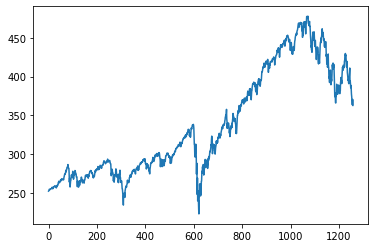

In [182]:
#now i would like to generate a quick visula to examine how the general variation has been for over the past 5 plus years
import matplotlib.pyplot as plt
plt.plot(df1)

In [183]:
#LSTM in general is very sensitive to the scale of data , in order to circumvent this issue we decide to scale the input 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [184]:
df1.shape

(1258, 1)

In [185]:
#now it is time to pre-process the data
#followed by this we will be splitting the data set in-to train and test
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size

In [186]:
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [187]:
#I will not convert an array into a timestep matrix to develop the model
import numpy as np 
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [188]:
#hyper parameter tuning has to be performed in-order to determine the ideal value of timestep
timestep=100
X_train,y_train = create_dataset(train_data,timestep)
X_test,y_test  = create_dataset(test_data,timestep)

In [189]:
#just for the sake of verification 
print(X_train)

[[0.11528497 0.11740462 0.1185822  ... 0.18487989 0.18625373 0.20317161]
 [0.11740462 0.1185822  0.12447009 ... 0.18625373 0.20317161 0.2156932 ]
 [0.1185822  0.12447009 0.12333176 ... 0.20317161 0.2156932  0.20207254]
 ...
 [0.41544984 0.42043492 0.42848171 ... 0.57399121 0.56880986 0.5663762 ]
 [0.42043492 0.42848171 0.43719579 ... 0.56880986 0.5663762  0.56767153]
 [0.42848171 0.43719579 0.43813786 ... 0.5663762  0.56767153 0.57328466]]


In [190]:
#the third step is to now create a stacked LSTM model 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [211]:
#we will now begin creating a stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()

In [212]:
model=Sequential()

In [213]:
model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(150,return_sequences=True))
model.add(LSTM(150))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [214]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100, 150)          91200     
                                                                 
 lstm_21 (LSTM)              (None, 100, 150)          180600    
                                                                 
 lstm_22 (LSTM)              (None, 150)               180600    
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 452,551
Trainable params: 452,551
Non-trainable params: 0
_________________________________________________________________


In [215]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 581ms/step - loss: 0.0175 - val_loss: 0.0112
Epoch 2/100
12/12 [==============================] - 6s 474ms/step - loss: 0.0032 - val_loss: 0.0113
Epoch 3/100
12/12 [==============================] - 6s 480ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 4/100
12/12 [==============================] - 6s 479ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 5/100
12/12 [==============================] - 6s 481ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 6/100
12/12 [==============================] - 6s 475ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 7/100
12/12 [==============================] - 6s 475ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 8/100
12/12 [==============================] - 6s 484ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/100
12/12 [==============================] - 6s 490ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 10/100
12/12 [==============================] - 6s 481ms/step - loss: 0.0012 - val_l

In [216]:
import tensorflow as tf

In [217]:
tf.__version__

'2.7.0'

In [218]:
#now let us begin the prediction phase 
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [219]:
#scaled inputs now have to be converted to its original format so we perform a reverse transform 
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [220]:
import math 
from sklearn.metrics import mean_squared_error
rmse=math.sqrt(mean_squared_error(y_train, train_predict))
print(rmse," is the value of root mean squared error for training data ")

297.05605606431527  is the value of root mean squared error for training data 


In [221]:
rmse_test=math.sqrt(mean_squared_error(y_test, test_predict))
print("for testing data we have ",rmse_test )

for testing data we have  432.50202061240407


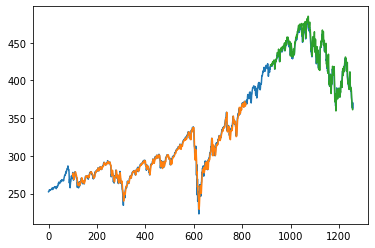

In [222]:
#now i am going to try and predict the values via a graph 
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot [:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like (df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [223]:
#now I am going to try to predit the future 60-65 days because dr.cho wanted to know the closing rate during december 1`

In [224]:
X_input = test_data[340:].reshape(1,-1)
X_input.shape

(1, 101)

In [225]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [226]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<64):
    
    if(len(temp_input)>100):
        #print(temp_input)
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input = X_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(X_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input = X_input.reshape((1, n_steps,1))
        yhat = model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.68778458 0.69139582 0.66650966 0.6649003  0.70171927 0.69532109
 0.727626   0.66301617 0.65359554 0.65426284 0.682878   0.67098446
 0.68464437 0.71581096 0.75486733 0.74572146 0.73261108 0.76322814
 0.73634008 0.74124666 0.75675145 0.73900926 0.70062019 0.65493013
 0.59683624 0.59240069 0.61332234 0.56406029 0.56095933 0.59711101
 0.59444183 0.60884754 0.6560292  0.65018056 0.61901397 0.61779714
 0.60566808 0.62132988 0.62415607 0.62921966 0.65175067 0.65049458
 0.63306642 0.61972052 0.61187    0.60825875 0.63659915 0.62411682
 0.66462553 0.67443869 0.69021824 0.67569477 0.6775789  0.65920867
 0.69905009 0.71879416 0.74203172 0.7372429  0.72660543 0.75168786
 0.75058879 0.74784111 0.74595698 0.73951955 0.77343382 0.77343382
 0.80134244 0.8082509  0.81154812 0.79957607 0.8044434  0.78187314
 0.74737007 0.74344481 0.74862616 0.77154969 0.71581096 0.70529125
 0.68794159 0.67604805 0.68091537 0.66450777 0.65869838 0.68625373
 0.69645941 0.72087455 0.73802795 0.6678835  0.673

In [227]:
day_new=np.arange(1,101)
day_pred=np.arange(101,165)

In [228]:
len(df1)

1258

In [229]:
print(1257+64)
df3=df1.tolist()
df3.extend(lst_output)

1321


In [230]:
df3=scaler.inverse_transform(df3).tolist()

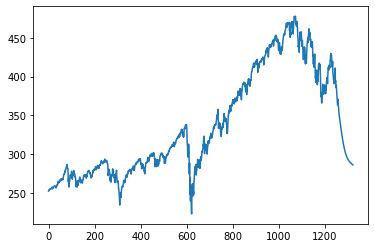

In [231]:
plt.plot(df3)

In [232]:
#the line towards the end which has the prediction profile has been smoothened by the ML model

In [234]:
prediction=df3[-2]

In [238]:
print(286.30252364993095*10," is the price of closing stock december 1 ")

2863.0252364993094  is the price of closing stock december 1 
